In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import qmc
from tqdm import tqdm
import random
from IPython.display import display
import json
from sklearn.ensemble import IsolationForest
import time

# Expanded data:
1. source, 
2. target, 
3. commits, 
4. additions (loc), 
5. deleteion (loc), 
6. changed files, comments, 
7. review comments, 
8. title lenght (n char), 
9. body lenght (n char), 
10. day of week created, 
11. time created

(loc): lines of code
(n char): number of characters

In [2]:
# Read the data, keep the requiered columns:
df = pd.read_csv('/Volumes/GoogleDrive-116698033185964814580/My Drive/Socialz/cobol_pullrequests.csv', 
                    usecols=['login', 'name', 'payload', 'created_at','commits', 'additions','deletions','changed_files'])

# Add user (u: ) repo (r: ) indicator for each node
df['login'] = df['login'].apply(lambda x: 'u: '+x)
df['name']  = df['name'].apply(lambda x: 'r: '+x)

# List user and repos
users = df['login'].unique().tolist()
repos = df['name'].unique().tolist()

# Returns the length of characters of a text
def text_lenght(text):

    if text == None:

        return 0
    else:

        return len(text)

# Expand nested features requeried for detecting anomalies
df['payload']                   = df['payload'].apply(json.loads)
df['comments']                  = df['payload'].apply(lambda x: x.get('pull_request').get('comments'))
df['review_comments']           = df['payload'].apply(lambda x: x.get('pull_request').get('review_comments'))
df['title_lenght']              = df['payload'].apply(lambda x: text_lenght(x.get('pull_request').get('title')))
df['body_lenght']               = df['payload'].apply(lambda x: text_lenght(x.get('pull_request').get('body')))
df['created_at_day_of_week']    = pd.to_datetime(df['created_at'],format= '%Y-%m-%d %H:%M:%S %Z').dt.day_of_week
df['created_at_time']           = round(pd.to_datetime(df['created_at'],format= '%Y-%m-%d %H:%M:%S %Z').dt.hour + \
                                        pd.to_datetime(df['created_at'],format= '%Y-%m-%d %H:%M:%S %Z').dt.minute / 60 + \
                                        pd.to_datetime(df['created_at'],format= '%Y-%m-%d %H:%M:%S %Z').dt.second / 3600, 3)

# Drop no longer required columns
df = df.drop(['created_at', 'payload'], axis=1)

#Rename columns
df = df.rename(columns={"login":"source","name":"target"})

# Display
df

,source,target,commits,additions,deletions,changed_files,comments,review_comments,title_lenght,body_lenght,created_at_day_of_week,created_at_time
0,u: vim-sroberge,r: vimaec/g3d,1,2,2,1,0,0,15,0,2,15.638
1,u: vim-sroberge,r: vimaec/g3d,1,2,2,1,0,0,15,0,2,15.470
2,u: vim-sroberge,r: vimaec/g3d,1,23,11,1,0,0,12,83,2,16.332
3,u: vim-sroberge,r: vimaec/g3d,1,23,11,1,0,0,12,83,2,15.632
4,u: mavimaec,r: vimaec/g3d,2,113,702,16,0,0,15,0,4,20.681
...,...,...,...,...,...,...,...,...,...,...,...,...
1328,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,1,688,1,39,0,0,75,155,4,3.725
1329,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,1,506,0,15,0,1,65,114,0,17.933
1330,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,1,506,0,15,0,0,65,0,1,22.209
1331,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,1,5,1,1,0,0,52,1092,3,4.026


# Anomaly detection, Isolation Forest:

In [3]:
# Predict the anomaly of a column based on previous features
predictions = pd.Series(dtype=int)

# Make the prediction based on each user
for user in users:
    clf = IsolationForest(max_samples='auto', n_jobs=-1, random_state=42)
    aux = df[df['source']==user].copy()
    aux.loc[:,'pred'] = clf.fit_predict(aux.iloc[:,2:])
    predictions = pd.concat([predictions, aux['pred']], axis=0)

# Drop no longer required columns
df = df[['source', 'target']]

# Add predictions
df = pd.concat([df, predictions.rename('prediction')], axis=1)

# Display
df

,source,target,prediction
0,u: vim-sroberge,r: vimaec/g3d,1
1,u: vim-sroberge,r: vimaec/g3d,1
2,u: vim-sroberge,r: vimaec/g3d,-1
3,u: vim-sroberge,r: vimaec/g3d,1
4,u: mavimaec,r: vimaec/g3d,1
...,...,...,...
1328,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,-1
1329,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,-1
1330,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,-1
1331,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples,-1


## Get anomaly ratio:

In [4]:
def get_anomaly_ratio(df):
    frame = df.copy()
    # Merge source / target to get a new column with users only:
    frame['source'] = frame['source'].where(frame['source'].str.startswith('u:'),frame['target'])
    # Group results by user and compute the anomaly ratio:
    frame = pd.concat([frame['source'], pd.get_dummies(frame['prediction'])], axis=1)
    frame = frame.groupby(by='source', as_index=True).sum()
    frame.index.name = None
    frame['anomaly_ratio'] = frame[-1] / (frame[-1] + frame[1])
    frame = frame.drop([-1,1], axis=1)
    # Return anomaly ratio by user
    return frame

anomaly = get_anomaly_ratio(df)
anomaly

,anomaly_ratio
u: APSDevp,0.208333
u: Adityan-compile,0.333333
u: AkinJimoh,0.363636
u: AlbGarciam,0.000000
u: AnthonyGiorgio,0.000000
...,...
u: whitesource-bolt-for-github[bot],0.000000
u: wilbertkho,0.000000
u: willdoescode,0.156863
u: writ3it,0.000000


In [5]:
# Mutator, give it an edge_list, and it will return the mutated edge_list.

def mutate(edge_list, node, repos):

  # Create copy of edge_lis:
  el          = edge_list.copy()

  # Mutate edges:
  new_edge_user_repo = pd.DataFrame({'source':[node], 'target':[random.choice(repos)], 'prediction':[random.choice([-1,1])]})
  new_edge_repo_user = pd.DataFrame({'source':[random.choice(repos)], 'target':[node], 'prediction':[random.choice([-1,1])]})

  # Add mutation to the edge_list:
  el = pd.concat([el, new_edge_repo_user, new_edge_user_repo], ignore_index=True, axis=0)
  
  return el

In [6]:
def user_user_similarity(adj_matrix, repos):

    ## Get repo - user similarity (upper-right square):
    repo_user = adj_matrix.iloc[:len(repos),len(repos):]
    repo_user = repo_user/np.linalg.norm(repo_user,axis=0,keepdims=True)
    repo_user[np.isnan(repo_user)] = 0
    repo_user = np.dot(repo_user.transpose(),repo_user)

    ## Get user - repo similarity (lower-left square):
    user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
    user_repo = user_repo/np.linalg.norm(user_repo,axis=1,keepdims=True)
    user_repo[np.isnan(user_repo)] = 0
    user_repo = np.dot(user_repo, user_repo.transpose())

    # Combine upper and lower triangles, keep 0 in the diagonal.
    user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

    # return user_user
    return user_user

In [7]:
# Compute graph metrics, betweenness centrality and node degree

def graph_metrics(edge_list, centrality):

     # Build the adjacency matrix for user - repo (and repo - user) interactions.
     adj_matrix = pd.crosstab(edge_list['source'], edge_list['target']).astype(float)
     idx = adj_matrix.columns.union(adj_matrix.index)
     adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0)

     # Evaluate user-user similarity:
     adj_matrix.loc[users, users] = user_user_similarity(adj_matrix, repos)

     G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

     # nx.eigenvector_centrality
     if centrality == nx.eigenvector_centrality:
          centrality_column = 'eigenvector_centrality'
          result = None
          i = 500
          tol = 1.0e-6
          while result is None:
               try:
                    result = {'degree' : {node:val for (node, val) in G.degree()},
                              centrality_column: nx.eigenvector_centrality(G, max_iter=i, tol=tol)}
               except nx.exception.PowerIterationFailedConvergence:
                    i += 500
                    if i > 10000:
                         tol = 1.0e-5

     # nx.katz_centrality:
     if centrality == nx.katz_centrality:
          centrality_column = 'katz_centrality'
          result = None
          i = 1000
          tol = 1.0e-6
          while result is None:
               try:
                    result = {'degree' : {node:val for (node, val) in G.degree()} ,
                              centrality_column : centrality(G,normalized=False,max_iter=i,tol=tol)}
               except nx.exception.PowerIterationFailedConvergence:
                    i += 500
                    if i > 10000:
                         tol = 1.0e-5

     # nx.pagerank:
     if centrality == nx.pagerank:
          centrality_column = 'pagerank'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column : centrality(G)}

     # nx.betweenness_centrality
     if centrality == nx.betweenness_centrality:
          centrality_column = 'betweenness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column : centrality(G,normalized=False)}

     # nx.degree_centrality
     if centrality == nx.degree_centrality:
          centrality_column = 'degree_centrality'
          s = 1.0 / (len(G) - 1.0)
          result = nx.degree_centrality(G)
          result = {k: v/s for k,v in result.items()} # undo normalisation
          result = {centrality_column:result}
          aux = {'degree' : {node:val for (node, val) in G.degree()}}
          result = aux | result # merge dicts

     # nx.closeness_centrality
     if centrality == nx.closeness_centrality:
          centrality_column = 'closeness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column:nx.closeness_centrality(G, wf_improved=False)}

     # Dict to DataFrame, normalise values
     # normalise node degree values  https://www.statology.org/normalize-data-between-0-and-1/
     # zi = (xi – min(x)) / (max(x) – min(x))
     result = pd.DataFrame(result)
     result['degree'] = result['degree'].apply(lambda x: (x - result['degree'].min())/(result['degree'].max() - result['degree'].min()))
     result[centrality_column] = result[centrality_column].apply(lambda x: (x - result[centrality_column].min())/(result[centrality_column].max() - result[centrality_column].min()))

     # filter users
     result = result[result.index.str.startswith('u: ')]

     # add anomaly ratio:
     abnormal_ratio = get_anomaly_ratio(edge_list)
     abnormal_ratio['anomaly_ratio'] = abnormal_ratio['anomaly_ratio'].apply(lambda x: (x - abnormal_ratio['anomaly_ratio'].min())/(abnormal_ratio['anomaly_ratio'].max() - abnormal_ratio['anomaly_ratio'].min()))
     result = pd.concat([result, abnormal_ratio], axis=1)

     return result


# Metrics for each node, 
## to evaluate star-discrepancy:

In [8]:
result = graph_metrics(df, nx.katz_centrality)
result

,degree,katz_centrality,anomaly_ratio
u: APSDevp,0.083333,0.027693,0.297619
u: Adityan-compile,0.000000,0.000000,0.476190
u: AkinJimoh,0.041667,0.000000,0.519481
u: AlbGarciam,0.666667,0.376051,0.000000
u: AnthonyGiorgio,0.083333,0.058154,0.000000
...,...,...,...
u: whitesource-bolt-for-github[bot],0.000000,0.000000,0.000000
u: wilbertkho,0.666667,0.513176,0.000000
u: willdoescode,0.000000,0.000000,0.224090
u: writ3it,0.000000,0.000000,0.000000


In [9]:
# Evaluate metrics in terms of star-discrepancy

def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [10]:
# evolution strategy (mu, lambda) algorithm

def es_plus(edge_list, users, repos, objective, n_iter, mu, lam, centrality):
  best, best_eval, start = None, 1e+10, time.time()

	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = edge_list.copy()            # copy the initial edge_list
    population.append(candidate)            # add to population

  # perform the search
  for epoch in range(n_iter):
    # evaluate the fitness for the population
    scores = [objective(graph_metrics(candidate,centrality)) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval, niter = population[i], scores[i], epoch
        print('%d, Best eval: = %.5f' % (epoch, best_eval))
        
      # keep the parent
      offspring.append(population[i])

      # create offspring for parent
      for j in range(n_children):
        sample = np.random.choice(users)
        child = mutate(population[i], sample, repos)
        offspring.append(child)

    # replace population with children
    population = offspring
  
  end = time.time()
  total_time = end - start
  return [niter, best, best_eval, total_time]

# Experimental results:
## (1 + 1)-EA, 3D feature space, edge list

1.1 (1 + 1) Betweenness centrality evaluation:

In [11]:
n_iter, mu, lam, centrality = 1000, 1, 1, nx.betweenness_centrality
niter, best, best_eval, total_time = es_plus(df, users, repos, objective,n_iter, mu, lam, centrality)

0, Best eval: = 0.49866
1, Best eval: = 0.49608
2, Best eval: = 0.49082
5, Best eval: = 0.48638
6, Best eval: = 0.48404
7, Best eval: = 0.47674
8, Best eval: = 0.46734
10, Best eval: = 0.45920
18, Best eval: = 0.45283
19, Best eval: = 0.45070
22, Best eval: = 0.44795
26, Best eval: = 0.44519
29, Best eval: = 0.44519
31, Best eval: = 0.43822
46, Best eval: = 0.43170
48, Best eval: = 0.42548
58, Best eval: = 0.41554
64, Best eval: = 0.41472
65, Best eval: = 0.40674
81, Best eval: = 0.40190
82, Best eval: = 0.39479
96, Best eval: = 0.38995
98, Best eval: = 0.38567
101, Best eval: = 0.37661
103, Best eval: = 0.36682
107, Best eval: = 0.36048
112, Best eval: = 0.35403
113, Best eval: = 0.35403
133, Best eval: = 0.34539
134, Best eval: = 0.34056
144, Best eval: = 0.33893
146, Best eval: = 0.33893
161, Best eval: = 0.33427
165, Best eval: = 0.32809
170, Best eval: = 0.31585
180, Best eval: = 0.31150
283, Best eval: = 0.30715
289, Best eval: = 0.30653
292, Best eval: = 0.30611
302, Best eval: 

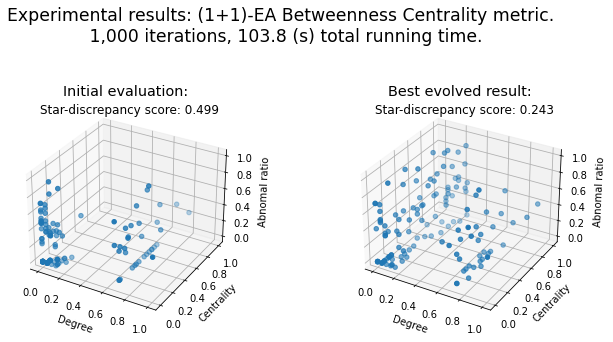

In [12]:
fig1, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(10,6), subplot_kw=dict(projection="3d"))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
result1 = graph_metrics(df, centrality)
ax1.scatter3D(result1['degree'], result1[str(centrality).split(' ')[1]], result1['anomaly_ratio'])
ax1.set_xlabel('Degree')
ax1.set_ylabel('Centrality')
ax1.set_zlabel('Abnomal ratio')
result = graph_metrics(best, centrality)
ax2.scatter3D(result['degree'], result[str(centrality).split(' ')[1]], result['anomaly_ratio'])
ax2.set_xlabel('Degree')
ax2.set_ylabel('Centrality')
ax2.set_zlabel('Abnomal ratio')
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved result:',fontsize='x-large')
ax1.text(0.8,0,2,f'Star-discrepancy score: {objective(result1):.3f}',fontsize='large',horizontalalignment='center')
ax2.text(0.8,0,2,f'Star-discrepancy score: {objective(result):.3f}',fontsize='large',horizontalalignment='center')
fig1.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, {total_time:.1f} (s) total running time.",fontsize='xx-large')
plt.show()

1.1 (1 + 1) Closeness centrality evaluation:

In [13]:
n_iter, mu, lam, centrality = 1000, 1, 1, nx.closeness_centrality
niter, best, best_eval, total_time = es_plus(df, users, repos, objective,n_iter, mu, lam, centrality)

0, Best eval: = 0.29124
1, Best eval: = 0.29124
4, Best eval: = 0.28702
6, Best eval: = 0.28289
7, Best eval: = 0.27953
9, Best eval: = 0.26998
10, Best eval: = 0.26983
11, Best eval: = 0.26746
12, Best eval: = 0.26077
13, Best eval: = 0.26054
14, Best eval: = 0.25560
15, Best eval: = 0.25560
19, Best eval: = 0.25289
20, Best eval: = 0.25089
21, Best eval: = 0.24605
22, Best eval: = 0.23863
23, Best eval: = 0.23224
24, Best eval: = 0.23224
25, Best eval: = 0.22416
29, Best eval: = 0.22029
30, Best eval: = 0.21674
32, Best eval: = 0.21674
37, Best eval: = 0.20595
40, Best eval: = 0.20541
44, Best eval: = 0.20522
45, Best eval: = 0.20152
46, Best eval: = 0.19514
47, Best eval: = 0.19227
51, Best eval: = 0.18952
52, Best eval: = 0.18826
53, Best eval: = 0.18826
60, Best eval: = 0.18264
61, Best eval: = 0.18083
68, Best eval: = 0.17504
69, Best eval: = 0.17390
73, Best eval: = 0.16964
75, Best eval: = 0.16843
76, Best eval: = 0.16843
84, Best eval: = 0.16607
88, Best eval: = 0.16495
92, Be

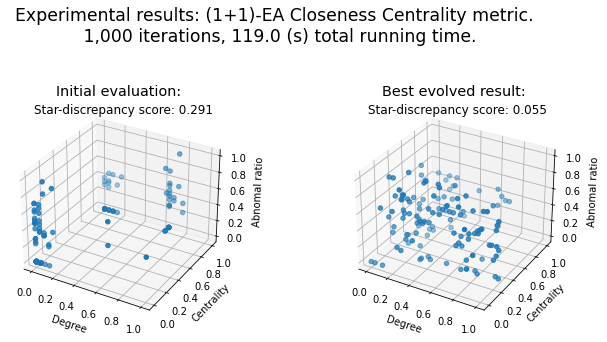

In [14]:
fig2, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(10,6), subplot_kw=dict(projection="3d"))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
result1 = graph_metrics(df, centrality)
ax1.scatter3D(result1['degree'], result1[str(centrality).split(' ')[1]], result1['anomaly_ratio'])
ax1.set_xlabel('Degree')
ax1.set_ylabel('Centrality')
ax1.set_zlabel('Abnomal ratio')
result = graph_metrics(best, centrality)
ax2.scatter3D(result['degree'], result[str(centrality).split(' ')[1]], result['anomaly_ratio'])
ax2.set_xlabel('Degree')
ax2.set_ylabel('Centrality')
ax2.set_zlabel('Abnomal ratio')
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved result:',fontsize='x-large')
ax1.text(0.8,0,2,f'Star-discrepancy score: {objective(result1):.3f}',fontsize='large',horizontalalignment='center')
ax2.text(0.8,0,2,f'Star-discrepancy score: {objective(result):.3f}',fontsize='large',horizontalalignment='center')
fig2.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, {total_time:.1f} (s) total running time.",fontsize='xx-large')
plt.show()

1.1 (1 + 1) Eigenvector centrality evaluation:

In [15]:
n_iter, mu, lam, centrality = 1000, 1, 1, nx.eigenvector_centrality
niter, best, best_eval, total_time = es_plus(df, users, repos, objective,n_iter, mu, lam, centrality)

0, Best eval: = 0.53715
1, Best eval: = 0.53368
2, Best eval: = 0.53043
3, Best eval: = 0.52769
4, Best eval: = 0.52250
5, Best eval: = 0.51923
6, Best eval: = 0.51856
7, Best eval: = 0.51523
8, Best eval: = 0.50618
9, Best eval: = 0.50528
10, Best eval: = 0.50492
11, Best eval: = 0.50043
14, Best eval: = 0.49994
15, Best eval: = 0.49363
16, Best eval: = 0.48872
17, Best eval: = 0.48811
18, Best eval: = 0.48731
20, Best eval: = 0.48719
21, Best eval: = 0.48652
22, Best eval: = 0.48306
23, Best eval: = 0.48167
25, Best eval: = 0.48013
26, Best eval: = 0.48013
27, Best eval: = 0.47895
28, Best eval: = 0.47836
29, Best eval: = 0.47139
31, Best eval: = 0.46767
32, Best eval: = 0.46401
33, Best eval: = 0.46364
34, Best eval: = 0.46113
36, Best eval: = 0.46046
37, Best eval: = 0.45449
38, Best eval: = 0.45163
39, Best eval: = 0.45066
40, Best eval: = 0.44875
41, Best eval: = 0.44781
42, Best eval: = 0.44103
44, Best eval: = 0.44078
45, Best eval: = 0.43681
46, Best eval: = 0.43343
47, Best e

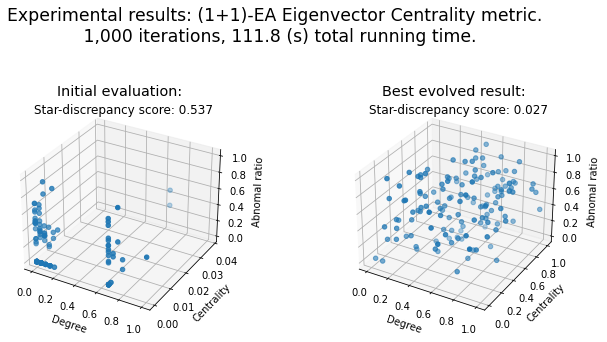

In [16]:
fig3, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(10,6), subplot_kw=dict(projection="3d"))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
result1 = graph_metrics(df, centrality)
ax1.scatter3D(result1['degree'], result1[str(centrality).split(' ')[1]], result1['anomaly_ratio'])
ax1.set_xlabel('Degree')
ax1.set_ylabel('Centrality')
ax1.set_zlabel('Abnomal ratio')
result = graph_metrics(best, centrality)
ax2.scatter3D(result['degree'], result[str(centrality).split(' ')[1]], result['anomaly_ratio'])
ax2.set_xlabel('Degree')
ax2.set_ylabel('Centrality')
ax2.set_zlabel('Abnomal ratio')
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved result:',fontsize='x-large')
ax1.text(0.8,0,2,f'Star-discrepancy score: {objective(result1):.3f}',fontsize='large',horizontalalignment='center')
ax2.text(0.8,0,2,f'Star-discrepancy score: {objective(result):.3f}',fontsize='large',horizontalalignment='center')
fig3.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, {total_time:.1f} (s) total running time.",fontsize='xx-large')
plt.show()

1.1 (1 + 1) Katz centrality evaluation:

In [17]:
n_iter, mu, lam, centrality = 1000, 1, 1, nx.katz_centrality
niter, best, best_eval, total_time = es_plus(df, users, repos, objective,n_iter, mu, lam, centrality)

0, Best eval: = 0.49981
1, Best eval: = 0.49845
2, Best eval: = 0.49839
3, Best eval: = 0.49572
4, Best eval: = 0.49465
5, Best eval: = 0.48751
6, Best eval: = 0.48642
7, Best eval: = 0.48020
8, Best eval: = 0.47611
9, Best eval: = 0.47498
10, Best eval: = 0.46783
11, Best eval: = 0.46709
12, Best eval: = 0.46398
13, Best eval: = 0.46244
14, Best eval: = 0.45903
15, Best eval: = 0.45360
16, Best eval: = 0.45023
17, Best eval: = 0.44906
19, Best eval: = 0.44629
20, Best eval: = 0.44628
21, Best eval: = 0.44015
22, Best eval: = 0.43930
23, Best eval: = 0.43594
24, Best eval: = 0.43383
25, Best eval: = 0.43273
26, Best eval: = 0.42869
27, Best eval: = 0.42791
28, Best eval: = 0.42688
29, Best eval: = 0.42320
31, Best eval: = 0.42044
32, Best eval: = 0.42044
33, Best eval: = 0.42005
34, Best eval: = 0.41955
35, Best eval: = 0.41861
36, Best eval: = 0.41611
37, Best eval: = 0.41499
38, Best eval: = 0.41429
40, Best eval: = 0.41095
41, Best eval: = 0.40980
42, Best eval: = 0.40928
43, Best e

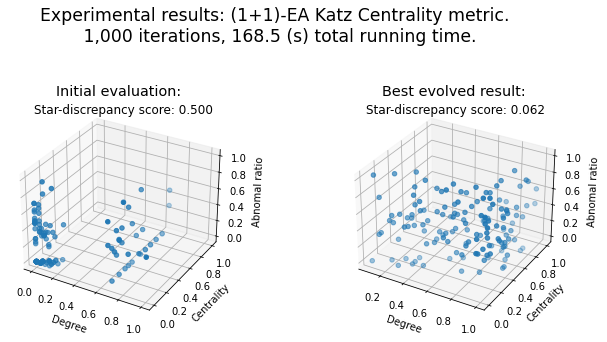

In [18]:
fig4, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(10,6), subplot_kw=dict(projection="3d"))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
result1 = graph_metrics(df, centrality)
ax1.scatter3D(result1['degree'], result1[str(centrality).split(' ')[1]], result1['anomaly_ratio'])
ax1.set_xlabel('Degree')
ax1.set_ylabel('Centrality')
ax1.set_zlabel('Abnomal ratio')
result = graph_metrics(best, centrality)
ax2.scatter3D(result['degree'], result[str(centrality).split(' ')[1]], result['anomaly_ratio'])
ax2.set_xlabel('Degree')
ax2.set_ylabel('Centrality')
ax2.set_zlabel('Abnomal ratio')
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved result:',fontsize='x-large')
ax1.text(0.8,0,2,f'Star-discrepancy score: {objective(result1):.3f}',fontsize='large',horizontalalignment='center')
ax2.text(0.8,0,2,f'Star-discrepancy score: {objective(result):.3f}',fontsize='large',horizontalalignment='center')
fig4.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, {total_time:.1f} (s) total running time.",fontsize='xx-large')
plt.show()

1.1 (1 + 1) Pagerank evaluation:

In [19]:
n_iter, mu, lam, centrality = 1000, 1, 1, nx.pagerank
niter, best, best_eval, total_time = es_plus(df, users, repos, objective,n_iter, mu, lam, centrality)

0, Best eval: = 0.52815
1, Best eval: = 0.52426
2, Best eval: = 0.52038
4, Best eval: = 0.51654
5, Best eval: = 0.51417
6, Best eval: = 0.51357
7, Best eval: = 0.51202
8, Best eval: = 0.51182
9, Best eval: = 0.51148
10, Best eval: = 0.50781
11, Best eval: = 0.50656
12, Best eval: = 0.50535
13, Best eval: = 0.50381
14, Best eval: = 0.50133
15, Best eval: = 0.49550
16, Best eval: = 0.49510
17, Best eval: = 0.49233
18, Best eval: = 0.48856
19, Best eval: = 0.48685
20, Best eval: = 0.48501
21, Best eval: = 0.48239
22, Best eval: = 0.48084
23, Best eval: = 0.48084
24, Best eval: = 0.47899
25, Best eval: = 0.47557
26, Best eval: = 0.47420
27, Best eval: = 0.47380
28, Best eval: = 0.46552
29, Best eval: = 0.46097
31, Best eval: = 0.45842
32, Best eval: = 0.45819
33, Best eval: = 0.45678
34, Best eval: = 0.45548
35, Best eval: = 0.45328
36, Best eval: = 0.45117
37, Best eval: = 0.44777
39, Best eval: = 0.44127
40, Best eval: = 0.43952
41, Best eval: = 0.43837
42, Best eval: = 0.43811
43, Best 

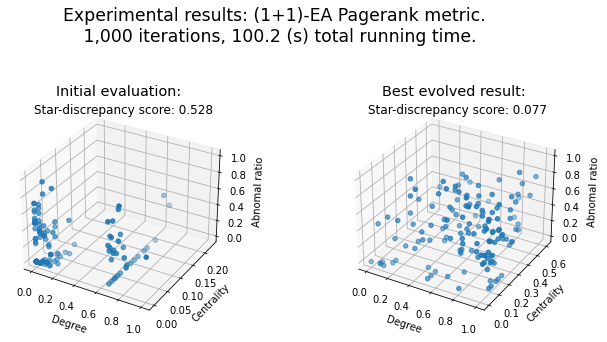

In [20]:
fig5, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(10,6), subplot_kw=dict(projection="3d"))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
result1 = graph_metrics(df, centrality)
ax1.scatter3D(result1['degree'], result1[str(centrality).split(' ')[1]], result1['anomaly_ratio'])
ax1.set_xlabel('Degree')
ax1.set_ylabel('Centrality')
ax1.set_zlabel('Abnomal ratio')
result = graph_metrics(best, centrality)
ax2.scatter3D(result['degree'], result[str(centrality).split(' ')[1]], result['anomaly_ratio'])
ax2.set_xlabel('Degree')
ax2.set_ylabel('Centrality')
ax2.set_zlabel('Abnomal ratio')
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved result:',fontsize='x-large')
ax1.text(0.8,0,2,f'Star-discrepancy score: {objective(result1):.3f}',fontsize='large',horizontalalignment='center')
ax2.text(0.8,0,2,f'Star-discrepancy score: {objective(result):.3f}',fontsize='large',horizontalalignment='center')
fig5.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, {total_time:.1f} (s) total running time.",fontsize='xx-large')
plt.show()

In [21]:
with PdfPages('3dexperiments.pdf') as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)
    pdf.savefig(fig5)